In [2]:
# retina
%config InlineBackend.figure_format = 'retina'

In [4]:
import os
from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.table import Table
import eazy

from matplotlib import rcParams
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 25

WD = Path('/data1/hbahk/spherex-photoz/spherex-challenge/challenge')
os.chdir(WD)

from utils import plot_comp_hexbin

In [72]:
syn = Table.read(WD/'data/spherex_synphot.dat', format='ascii.commented_header')
syn[:3]

id,F419,E419,F420,E420,F421,E421,F422,E422,F423,E423,F424,E424,F425,E425,F426,E426,F427,E427,F428,E428,F429,E429,F430,E430,F431,E431,F432,E432,F433,E433,F434,E434,F435,E435,F436,E436,F437,E437,F438,E438,F439,E439,F440,E440,F441,E441,F442,E442,F443,E443,F444,E444,F445,E445,F446,E446,F447,E447,F448,E448,F449,E449,F450,E450,F451,E451,F452,E452,F453,E453,F454,E454,F455,E455,F456,E456,F457,E457,F458,E458,F459,E459,F460,E460,F461,E461,F462,E462,F463,E463,F464,E464,F465,E465,F466,E466,F467,E467,F468,E468,F469,E469,F470,E470,F471,E471,F472,E472,F473,E473,F474,E474,F475,E475,F476,E476,F477,E477,F478,E478,F479,E479,F480,E480,F481,E481,F482,E482,F483,E483,F484,E484,F485,E485,F486,E486,F487,E487,F488,E488,F489,E489,F490,E490,F491,E491,F492,E492,F493,E493,F494,E494,F495,E495,F496,E496,F497,E497,F498,E498,F499,E499,F500,E500,F501,E501,F502,E502,F503,E503,F504,E504,F505,E505,F506,E506,F507,E507,F508,E508,F509,E509,F510,E510,F511,E511,F512,E512,F513,E513,F514,E514,F515,E515,F516,E516,F517,E517,F518,E518,F519,E519,F520,E520
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
180642,-12.93,10.04,4.18,10.46,12.45,10.53,-10.32,11.83,0.6,10.85,-5.49,9.34,2.98,10.72,13.86,9.59,-10.02,10.29,-6.82,10.42,27.23,9.13,-8.28,8.45,-3.51,6.44,2.49,8.21,10.66,8.29,-4.09,9.0,13.52,9.55,34.25,12.5,4.91,5.8,-6.65,6.88,0.72,6.89,4.82,7.01,-0.9,6.57,1.6,5.24,7.11,5.93,1.35,4.65,9.69,5.44,-0.38,6.23,-12.41,5.99,6.43,5.44,-4.11,6.47,-11.08,6.42,2.28,6.19,16.48,11.14,-4.16,6.91,-2.19,6.41,-3.11,10.02,-1.6,7.81,16.47,12.64,8.29,9.36,4.45,9.03,10.84,8.37,-2.91,8.04,7.52,7.34,-4.62,6.25,4.36,7.47,-1.3,7.47,-4.62,7.28,-1.75,7.18,3.17,7.23,1.13,9.37,-6.13,7.6,7.06,8.26,11.44,8.33,13.36,8.02,9.41,8.88,16.02,7.43,0.56,7.71,18.61,8.31,20.02,8.82,10.55,7.34,1.74,6.61,11.86,6.92,0.36,5.69,13.75,5.37,3.66,6.28,9.13,6.88,11.03,7.18,32.55,18.27,0.05,8.07,11.93,14.37,31.63,14.33,-17.03,14.37,13.86,14.41,-23.31,12.61,-2.0,14.43,5.6,11.1,9.79,13.73,1.69,15.94,2.03,16.12,-4.25,15.21,7.88,17.6,-16.08,17.71,6.25,17.38,-47.59,25.32,47.42,23.2,11.77,18.67,34.52,30.58,25.26,25.33,28.14,42.79,-59.15,35.28,60.1,34.4,-26.15,33.87,5.99,35.57,-3.53,32.0,-46.36,28.34,-109.88,35.92,-2.75,34.97,-55.47,39.18,0.74,36.54,-24.96,41.72,-54.64,37.64
180650,11.95,11.1,-17.29,10.8,-9.8,9.43,-5.06,9.01,-2.83,10.11,17.57,10.18,-16.88,10.32,18.33,8.2,-0.08,9.77,3.23,7.9,-0.2,8.22,8.48,8.37,1.34,7.4,7.25,6.74,4.53,7.92,-4.44,8.1,4.6,10.75,3.59,11.03,15

In [66]:
np.argwhere(syn['F480']>100)

array([[   363],
       [   389],
       [   394],
       ...,
       [165948],
       [165973],
       [165981]])

In [69]:
idx_target = 363
phot = np.array(list(syn[idx_target].values()))[1:]
flux = phot[::2]
erro = phot[1::2]
res = eazy.filters.FilterFile(WD/'FILTERS+spherex.res')
idx_sphx = res.search('SPHEREx', verbose=False)
res_sphx = np.array(res.filters)[idx_sphx]
wave = np.array([filt.pivot for filt in res_sphx])

<ErrorbarContainer object of 3 artists>

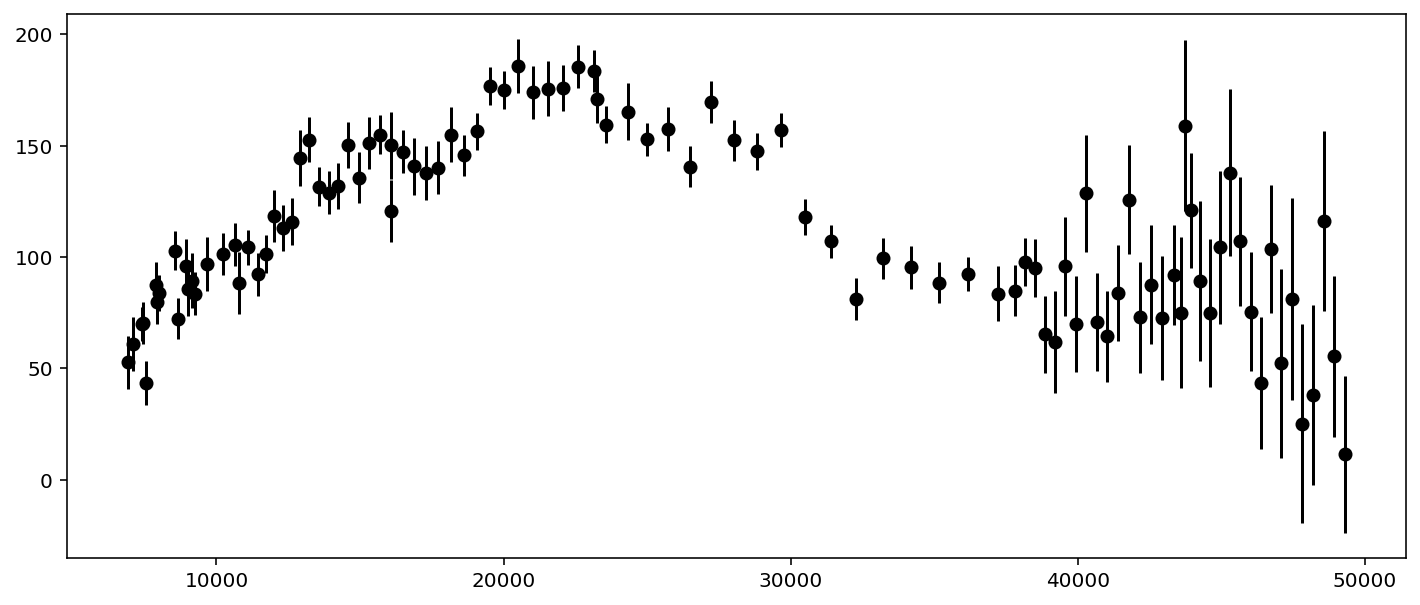

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.errorbar(wave, flux, yerr=erro, fmt='o', color='k')

In [89]:
idx_sphx_band1 = res.search('SPHEREx_Band1', verbose=False)
res_sphx_band1 = np.array(res.filters)[idx_sphx_band1]

filters = res_sphx_band1
fluxes = flux[:17]
errors = erro[:17]

weights = np.empty(len(filters), dtype=float)
for i, filt in enumerate(filters):
    if not hasattr(filt, 'weight'):
        filt.weight = np.trapz(filt.throughput*filt.wave, filt.wave)
    weights[i] = filt.weight

flux_combined = np.average(fluxes, weights=weights)
error_combined = np.sqrt(np.sum(errors**2*weights**2/weights.sum()**2))

pivot_combined_squred = np.average([filt.pivot**2 for filt in filters],
                                   weights=[filt.norm for filt in filters])
pivot_combined = np.sqrt(pivot_combined_squred)

# resample filters into the common wavelength grid
mean_sampling = np.mean([filt.wave[1]-filt.wave[0] for filt in filters])

eazy.filters.FilterDefinition('SPHEREx_Band1_combined', )

[2.52 2.51 2.52 2.51 2.52 2.51 2.52 2.51 2.52 2.51]
[2.51 2.51 2.52 2.51 2.51 2.51 2.51 2.51 2.51 2.51]
[2.51 2.51 2.5  2.51 2.51 2.5  2.51 2.51 2.5  2.51]


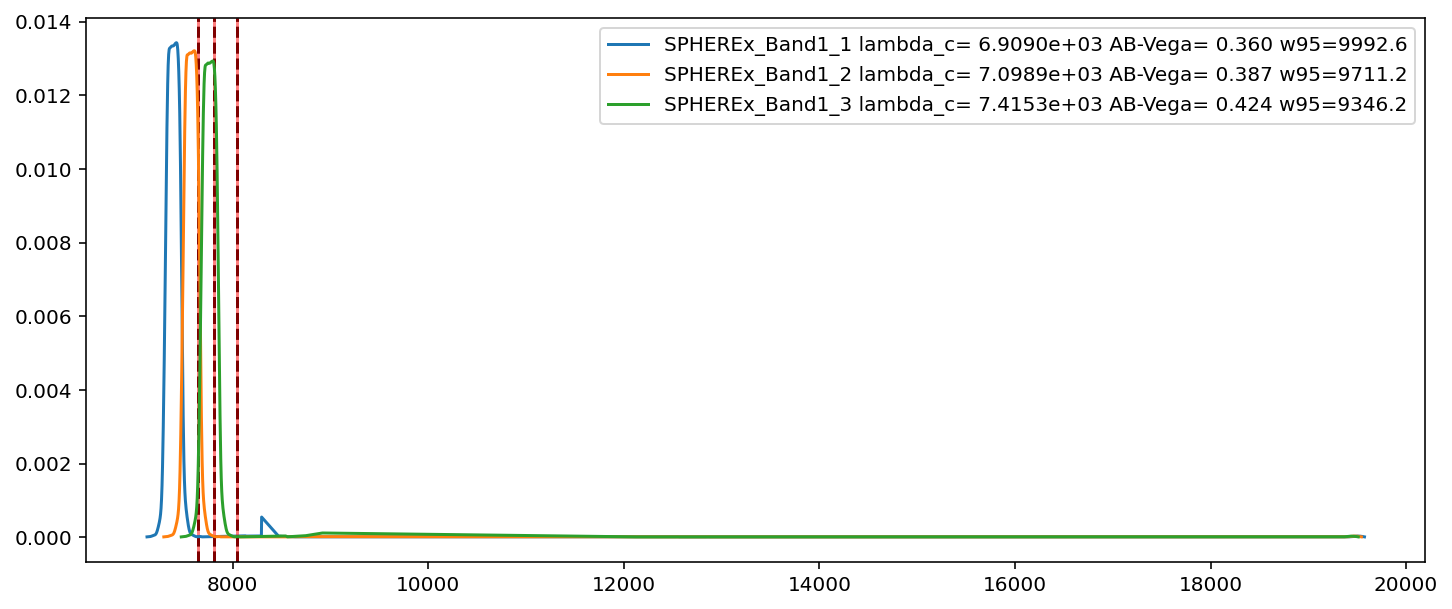

In [134]:
filters = res_sphx
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
for filt in filters[:3]:
    # mask = (filt.wave < filt.pivot + 3*filt.rectwidth) & (filt.wave > filt.pivot - 3*filt.rectwidth)
    my_piv = np.sqrt(np.trapz(filt.throughput*filt.wave,filt.wave)/np.trapz(filt.throughput/filt.wave,filt.wave))
    ax.axvline(filt.pivot, color='k', ls='--')
    ax.axvline(my_piv, color='r', ls='-', alpha=0.5)
    # ax.plot(filt.wave[mask], filt.throughput[mask], '.', label=filt.name)
    ax.plot(filt.wave, filt.throughput, label=filt.name)
    ax.legend()
    print(np.diff(filt.wave)[:10])


In [138]:
from utils import make_eazy_filters_spherex
res_nocut = make_eazy_filters_spherex(WD/'data'/'fiducial_filters_102',
                                      'FILTERS+spherex_nocut.res', threshold=0)

Wrote <FILTERS+spherex_nocut.res[.info]>


In [139]:
idx_sphx_nocut = res_nocut.search('SPHEREx', verbose=False)
res_sphx_nocut = np.array(res_nocut.filters)[idx_sphx_nocut]

[2.52 2.51 2.52 2.51 2.52 2.51 2.52 2.51 2.52 2.51]
[2.51 2.51 2.52 2.51 2.51 2.51 2.51 2.51 2.51 2.51]
[2.51 2.51 2.5  2.51 2.51 2.5  2.51 2.51 2.5  2.51]


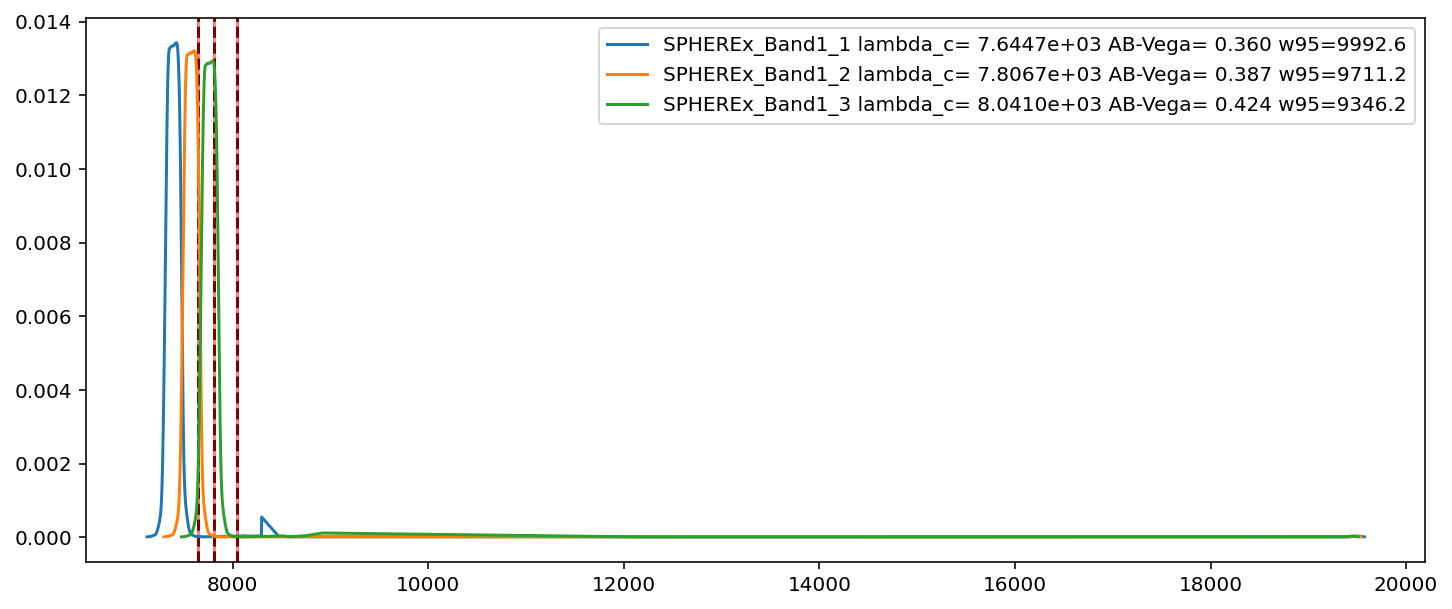

In [141]:
filters = res_sphx_nocut
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
for filt in filters[:3]:
    # mask = (filt.wave < filt.pivot + 2*filt.rectwidth) & (filt.wave > filt.pivot - 2*filt.rectwidth)
    my_piv = np.sqrt(np.trapz(filt.throughput*filt.wave,filt.wave)/np.trapz(filt.throughput/filt.wave,filt.wave))
    ax.axvline(filt.pivot, color='k', ls='--')
    ax.axvline(my_piv, color='r', ls='-', alpha=0.5)
    # ax.plot(filt.wave[mask], filt.throughput[mask], '.', label=filt.name)
    ax.plot(filt.wave, filt.throughput, label=filt.name)
    ax.legend()
    print(np.diff(filt.wave)[:10])

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.errorbar(wave, flux, yerr=erro, fmt='o', color='k')
ax.errorbar()

array(['SPHEREx_Band1_1 lambda_c= 6.9090e+03 AB-Vega= 0.360 w95=9992.6',
       'SPHEREx_Band1_2 lambda_c= 7.0989e+03 AB-Vega= 0.387 w95=9711.2',
       'SPHEREx_Band1_3 lambda_c= 7.4153e+03 AB-Vega= 0.424 w95=9346.2',
       'SPHEREx_Band1_4 lambda_c= 7.4454e+03 AB-Vega= 0.452 w95=9084.0',
       'SPHEREx_Band1_5 lambda_c= 7.5601e+03 AB-Vega= 0.484 w95=8761.8',
       'SPHEREx_Band1_6 lambda_c= 7.9043e+03 AB-Vega= 0.508 w95=8682.3',
       'SPHEREx_Band1_7 lambda_c= 7.9427e+03 AB-Vega= 0.553 w95=8377.5',
       'SPHEREx_Band1_8 lambda_c= 8.0093e+03 AB-Vega= 0.535 w95=8026.9',
       'SPHEREx_Band1_9 lambda_c= 8.6532e+03 AB-Vega= 0.550 w95=7737.0',
       'SPHEREx_Band1_10 lambda_c= 8.5533e+03 AB-Vega= 0.518 w95=7399.9',
       'SPHEREx_Band1_11 lambda_c= 9.2650e+03 AB-Vega= 0.561 w95=7028.0',
       'SPHEREx_Band1_12 lambda_c= 8.9319e+03 AB-Vega= 0.545 w95=6689.0',
       'SPHEREx_Band1_13 lambda_c= 9.6759e+03 AB-Vega= 0.572 w95=1186.8',
       'SPHEREx_Band1_14 lambda_c= 9.0150e+03 A

In [94]:
print([filt.equivwidth for filt in filters])

[2.5513366806890003, 2.5354247770245, 2.730071507233, 2.699923979672999, 2.9409297170944995, 2.6239414097110014, 2.6211847460905005, 2.6162464095704996, 3.4107144758640016, 2.623180536245, 3.1619985301945, 2.6491792356724995, 2.5607301994544995, 2.5532150579755006, 2.5620590072460003, 2.548295155819, 2.5278256125355005]


In [131]:
eazy.__file__

'/data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/__init__.py'